In [2]:
#!/usr/bin/env python
import numpy as np
import pandas as pd
import argparse
import copy
import torch
import torch.nn as nn
import joblib
import time
import sys
import os
import random
from matplotlib import pyplot as plt
from data.sparseloader import DataLoader
from data.data import LibSVMData, LibCSVData, LibSVMRegData
from data.sparse_data import LibSVMDataSp
from models.mlp import MLP_1HL, MLP_2HL, MLP_3HL
from models.dynamic_net import DynamicNet, ForwardType
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.optim import SGD, Adam

In [3]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

set_seed(42)

# Prepare Data

In [4]:
df = pd.read_csv('/notebooks/GrowNet/Regression/data/datwTestTrainSplit.csv')

list_of_features = [
    "claim_no",
    "occurrence_time", 
    "notidel", 
    "development_period", 
    "pmt_no",
    "log1_paid_cumulative",
    "max_paid_dev_factor",
    "min_paid_dev_factor",
]
output_field = ["claim_size"]
youtput="claim_size"

In [5]:
# Only take training subsection, we save the TEST part for the final final final validation
df_train = df.query('train_ind == 1')
df_test = df.query('train_ind == 0')

# Only consider relevant columns
df_train = df_train.filter(items = list_of_features + [youtput])
df_test = df_test.filter(items = list_of_features + [youtput])

# Extract values
X_train, y_train = df_train.iloc[:, :8].values, df_train.iloc[:,[8]]
X_test, y_test = df_test.iloc[:, :8].values, df_test.iloc[:,[8]]

# Rebuild split
u_cno = np.unique(df_train['claim_no'])
print(len(u_cno))

# 80 - 20% split based on claim_no: 
test_cnox = np.arange(1, int(len(u_cno)/5) + 1)*5 - 1

df_train_test = df_train[df.claim_no.isin(test_cnox)].copy()
df_train_train = df_train[~df.claim_no.isin(test_cnox)].copy()

2196


/tmp/ipykernel_43/2633011144.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_train_test = df_train[df.claim_no.isin(test_cnox)].copy()
/tmp/ipykernel_43/2633011144.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_train_train = df_train[~df.claim_no.isin(test_cnox)].copy()


In [6]:
# Saving train and test into npz file
#np.savez('datwTestTrainSplit_train.npz', features=X_train, labels=y_train)
np.savez('data/datwTestTrainSplit_test.npz', features=X_test, labels=y_test)

# Load Model

In [7]:
class Options(object):
    def __init__(self, feat_d, hidden_d, batch_size, normalization, 
                 num_nets, boost_rate, lr, L2, epochs_per_stage, correct_epoch,
                 train, test, final_test, out_f) -> None:
        self.feat_d = feat_d
        self.hidden_d = hidden_d
        self.sparse = False
        self.batch_size = batch_size
        self.normalization = normalization
        self.tr = train
        self.te = test
        self.final_test = final_test
        self.cuda = True
        self.data = 'datwTestTrainSplit'
        self.cv = True
        self.num_nets = num_nets
        self.boost_rate = boost_rate
        self.lr = lr
        self.L2 = L2
        self.epochs_per_stage = epochs_per_stage
        self.correct_epoch = correct_epoch
        self.out_f = out_f

In [8]:
opt = Options(feat_d = 8, hidden_d = 64, batch_size = 2048, normalization = True, 
              num_nets = 100, boost_rate = 1.0, lr = 0.005, L2 = .0e-3,
              epochs_per_stage = 1, correct_epoch = 1,
              train = "/notebooks/GrowNet/Regression/data/datwTestTrainSplit_tr.npz", 
              test = "/notebooks/GrowNet/Regression/data/datwTestTrainSplit_te.npz",
              final_test = "/notebooks/GrowNet/Regression/data/datwTestTrainSplit_test.npz",
              out_f = "/notebooks/GrowNet/Regression/ckpt/datwTestTrainSplit_cls.pth")

In [9]:
def get_data():
    if opt.data in ['ca_housing', 'ailerons', 'YearPredictionMSD', 'slice_localization', 'datwTestTrainSplit']:
        train = LibSVMRegData(opt.tr, opt.feat_d, opt.normalization)
        test = LibSVMRegData(opt.te, opt.feat_d, opt.normalization)
        val = []
        if opt.cv:
            val = copy.deepcopy(train)
            print('Creating Validation set! \n')
            indices = list(range(len(train)))
            cut = int(len(train)*0.95)
            np.random.shuffle(indices)
            train_idx = indices[:cut]
            val_idx = indices[cut:]

            train.feat = train.feat[train_idx]
            train.label = train.label[train_idx]
            val.feat = val.feat[val_idx]
            val.label = val.label[val_idx]
    else:
        pass

    if opt.normalization:
        scaler = StandardScaler()
        scaler.fit(train.feat)
        train.feat = scaler.transform(train.feat)
        test.feat = scaler.transform(test.feat)
        if opt.cv:
            val.feat = scaler.transform(val.feat)
        joblib.dump(scaler, './ckpt/' + opt.data +'_scaler.pkl')
    print(f'#Train: {len(train)}, #Val: {len(val)} #Test: {len(test)}')
    return train, test, val, indices

In [10]:
train, test, val, indices = get_data()
N = len(train)
print(opt.data + ' training and test datasets are loaded!')

8
8
Creating Validation set! 

#Train: 65044, #Val: 3424 #Test: 17145
datwTestTrainSplit training and test datasets are loaded!


In [11]:
train_loader = DataLoader(train, opt.batch_size, shuffle=False, drop_last=False, num_workers=0) 
test_loader = DataLoader(test, opt.batch_size, shuffle=False, drop_last=False, num_workers=0)
if opt.cv:
    val_loader = DataLoader(val, opt.batch_size, shuffle=True, drop_last=False, num_workers=0)

In [12]:
best_rmse = pow(10, 6)
val_rmse = best_rmse
best_stage = opt.num_nets-1
c0 = np.mean(train.label)  #init_gbnn(train)
net_ensemble = DynamicNet(c0, opt.boost_rate)
loss_f1 = nn.MSELoss()
loss_models = torch.zeros((opt.num_nets, 3))

In [13]:
def get_optim(params, lr, weight_decay):
    optimizer = Adam(params, lr, weight_decay=weight_decay)
    #optimizer = SGD(params, lr, weight_decay=weight_decay)
    return optimizer

In [14]:
def root_mse(net_ensemble, loader):
    loss = 0
    total = 0

    for x, y in loader:
        if opt.cuda:
            x = x.cuda()

        with torch.no_grad():
            _, out = net_ensemble.forward(x)
        y = y.cpu().numpy().reshape(len(y), 1)
        out = out.cpu().numpy().reshape(len(y), 1)
        loss += mean_squared_error(y, out)* len(y)
        total += len(y)
    return np.sqrt(loss / total)

In [15]:
for stage in range(opt.num_nets):
    t0 = time.time()
    model = MLP_2HL.get_model(stage, opt)  # Initialize the model_k: f_k(x), multilayer perception v2
    if opt.cuda:
        model.cuda()

    optimizer = get_optim(model.parameters(), opt.lr, opt.L2)
    net_ensemble.to_train() # Set the models in ensemble net to train mode
    stage_mdlloss = []
    for epoch in range(opt.epochs_per_stage):
        for i, (x, y) in enumerate(train_loader):
                
            if opt.cuda:
                x= x.cuda()
                y = torch.as_tensor(y, dtype=torch.float32).cuda().view(-1, 1)
            middle_feat, out = net_ensemble.forward(x)
            out = torch.as_tensor(out, dtype=torch.float32).cuda().view(-1, 1)
            grad_direction = -(out-y)

            _, out = model(x, middle_feat)
            out = torch.as_tensor(out, dtype=torch.float32).cuda().view(-1, 1)
            loss = loss_f1(net_ensemble.boost_rate*out, grad_direction)  # T

            model.zero_grad()
            loss.backward()
            optimizer.step()
            stage_mdlloss.append(loss.item()*len(y))

    net_ensemble.add(model)
    sml = np.sqrt(np.sum(stage_mdlloss)/N)
        
    lr_scaler = 3
    # fully-corrective step
    stage_loss = []
    if stage > 0:
        # Adjusting corrective step learning rate 
        if stage % 15 == 0:
            #lr_scaler *= 2
            opt.lr /= 2
            opt.L2 /= 2
        optimizer = get_optim(net_ensemble.parameters(), opt.lr / lr_scaler, opt.L2)
        for _ in range(opt.correct_epoch):
            stage_loss = []
            for i, (x, y) in enumerate(train_loader):
                if opt.cuda:
                    x, y = x.cuda(), y.cuda().view(-1, 1)
                _, out = net_ensemble.forward_grad(x)
                out = torch.as_tensor(out, dtype=torch.float32).cuda().view(-1, 1)
                    
                loss = loss_f1(out, y) 
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                stage_loss.append(loss.item()*len(y))
    print(net_ensemble.boost_rate)
    # store model
    elapsed_tr = time.time()-t0
    sl = 0
    if stage_loss != []:
        sl = np.sqrt(np.sum(stage_loss)/N)

    print(f'Stage - {stage}, training time: {elapsed_tr: .1f} sec, model MSE loss: {sml: .5f}, Ensemble Net MSE Loss: {sl: .5f}')

    net_ensemble.to_file(opt.out_f)
    net_ensemble = DynamicNet.from_file(opt.out_f, lambda stage: MLP_2HL.get_model(stage, opt))

    if opt.cuda:
        net_ensemble.to_cuda()
    net_ensemble.to_eval() # Set the models in ensemble net to eval mode

    # Train
    tr_rmse  = root_mse(net_ensemble, train_loader)
    if opt.cv:
        val_rmse = root_mse(net_ensemble, val_loader) 
        if val_rmse < best_rmse:
            best_rmse = val_rmse
            best_stage = stage

    te_rmse  = root_mse(net_ensemble, test_loader)

    print(f'Stage: {stage}  RMSE@Tr: {tr_rmse:.5f}, RMSE@Val: {val_rmse:.5f}, RMSE@Te: {te_rmse:.5f}')

    loss_models[stage, 0], loss_models[stage, 1] = tr_rmse, te_rmse

tr_rmse, te_rmse = loss_models[best_stage, 0], loss_models[best_stage, 1]
print(f'Best validation stage: {best_stage}  RMSE@Tr: {tr_rmse:.5f}, final RMSE@Te: {te_rmse:.5f}')
loss_models = loss_models.detach().cpu().numpy()
fname =  './results/' + opt.data +'_rmse'
np.savez(fname, rmse=loss_models, params=opt) 

Parameter containing:
tensor(1., device='cuda:0', requires_grad=True)
Stage - 0, training time:  2.2 sec, model MSE loss:  262742.05618, Ensemble Net MSE Loss:  0.00000
Stage: 0  RMSE@Tr: 262729.63532, RMSE@Val: 259097.20700, RMSE@Te: 172212.10223
Parameter containing:
tensor(1.0564, device='cuda:0', requires_grad=True)
Stage - 1, training time:  1.1 sec, model MSE loss:  262715.34207, Ensemble Net MSE Loss:  262656.09642
Stage: 1  RMSE@Tr: 262649.60292, RMSE@Val: 259012.47308, RMSE@Te: 172132.97922
Parameter containing:
tensor(1.1123, device='cuda:0', requires_grad=True)
Stage - 2, training time:  1.4 sec, model MSE loss:  262594.47156, Ensemble Net MSE Loss:  262471.36001
Stage: 2  RMSE@Tr: 262456.71590, RMSE@Val: 258812.02648, RMSE@Te: 171974.45022
Parameter containing:
tensor(1.1680, device='cuda:0', requires_grad=True)
Stage - 3, training time:  1.3 sec, model MSE loss:  262348.49771, Ensemble Net MSE Loss:  262176.59798
Stage: 3  RMSE@Tr: 262154.42416, RMSE@Val: 258496.11551, RMS

In [16]:
net_ensemble = DynamicNet.from_file(opt.out_f, lambda stage: MLP_2HL.get_model(stage, opt))

# Compute RMSE

In [17]:
if opt.cuda:
        net_ensemble.to_cuda()
net_ensemble.to_eval()

In [18]:
out_test = torch.empty(0)

for x, y in test_loader:
    
    if opt.cuda:
            x = x.cuda()
            out_test = out_test.cuda()
    with torch.no_grad():
            _, out_tmp = net_ensemble.forward(x)
    out_test = torch.cat([out_test, out_tmp])

out_train = torch.empty(0)

for x, y in train_loader:
    
    if opt.cuda:
            x = x.cuda()
            out_train = out_train.cuda()
    with torch.no_grad():
            _, out_tmp = net_ensemble.forward(x)
    out_train = torch.cat([out_train, out_tmp])
    
if opt.cv:
    
    out_val = torch.empty(0)
    
    for x, y in val_loader:
    
        if opt.cuda:
                x = x.cuda()
                out_val = out_val.cuda()
        with torch.no_grad():
                _, out_tmp = net_ensemble.forward(x)
        out_val = torch.cat([out_val, out_tmp])

# Create results dataset

In [20]:
cut = int(len(indices)*0.95)
train_idx = indices[:cut]
val_idx = indices[cut:]

df_train_val = df_train_train.copy().iloc[val_idx]
df_train_train = df_train_train.iloc[train_idx]

In [21]:
df_train_test.loc[:,'claim_size_predicted'] = out_test.cpu().numpy().flatten()
df_train_train.loc[:,'claim_size_predicted'] = out_train.cpu().numpy().flatten()
df_train_val.loc[:,'claim_size_predicted'] = out_val.cpu().numpy().flatten()

df_train_test.loc[:,'train_ind'] = True
df_train_train.loc[:,'train_ind'] = True
df_train_val.loc[:,'train_ind'] = True
df_train = pd.concat([df_train_test, df_train_train, df_train_val])

In [22]:
def get_test_data():
    if opt.data in ['ca_housing', 'ailerons', 'YearPredictionMSD', 'slice_localization', 'datwTestTrainSplit']:
        test = LibSVMRegData(opt.final_test, opt.feat_d, opt.normalization)

    if opt.normalization:
        scaler = joblib.load('/notebooks/GrowNet/Regression/ckpt/datwTestTrainSplit_scaler.pkl')
        test.feat = scaler.transform(test.feat)
        print(f'#Final Test: {len(test)}')
    return test

In [23]:
final_test = get_test_data()
final_test_loader = DataLoader(final_test, opt.batch_size, shuffle=False, drop_last=False, num_workers=0) 

8
#Final Test: 57228


In [ ]:
root_mse(net_ensemble, final_test_loader)

In [24]:
out_final_test = torch.empty(0)

for x, y in final_test_loader:
    
    if opt.cuda:
            x = x.cuda()
            out_final_test = out_final_test.cuda()
    with torch.no_grad():
            _, out_tmp = net_ensemble.forward(x)
    out_final_test = torch.cat([out_final_test, out_tmp])

In [25]:
df_test.loc[:,'claim_size_predicted'] = out_final_test.cpu().numpy().flatten()
df_test.loc[:,'train_ind'] = False

In [26]:
df_test.head()

,claim_no,occurrence_time,notidel,development_period,pmt_no,log1_paid_cumulative,max_paid_dev_factor,min_paid_dev_factor,claim_size,claim_size_predicted,train_ind
0,1,0.734094,0.658094,1,0.0,0.000000,0.0,0.0,232310.088225,192644.468750,False
1,1,0.734094,0.658094,2,0.0,0.000000,0.0,0.0,232310.088225,220433.062500,False
2,1,0.734094,0.658094,3,0.0,0.000000,0.0,0.0,232310.088225,255575.828125,False
3,1,0.734094,0.658094,4,0.0,0.000000,0.0,0.0,232310.088225,290352.062500,False
4,1,0.734094,0.658094,5,1.0,9.490041,0.0,0.0,232310.088225,313037.562500,False


In [27]:
df_complete = pd.concat([df_train,df_test])
df_complete['occurrence_period'] = df_complete['occurrence_time'].apply(lambda x : np.ceil(x))

# Visualization

In [28]:
# Diagnostic model subplots
# We will be repeating this logic across multiple models, so put logic into function for repeatability

#COULD PLOT MEAN OR SUM

def make_model_subplots(df):
    fig, axes = plt.subplots(3, 2, sharex='all', sharey='all', figsize=(15, 15))

    (df
        .loc[lambda df: df.train_ind]
        .groupby(["occurrence_period"])
        .agg({youtput: "mean", "claim_size_predicted": "mean"})
    ).plot(ax=axes[0,0], logy=True)
    axes[0,0].title.set_text("Train, Occur")

    (df
        .loc[lambda df: df.train_ind]
        .groupby(["development_period"])
        .agg({youtput: "mean", "claim_size_predicted": "mean"})
    ).plot(ax=axes[0,1], logy=True)
    axes[0,1].title.set_text("Train, Dev")

    (df
        .loc[lambda df: ~df.train_ind]
        .groupby(["occurrence_period"])
        .agg({youtput: "mean", "claim_size_predicted": "mean"})
    ).plot(ax=axes[1,0], logy=True)
    axes[1,0].title.set_text("Test, Occ")

    (df
        .loc[lambda df: ~df.train_ind]
        .groupby(["development_period"])
        .agg({youtput: "mean", "claim_size_predicted": "mean"})
    ).plot(ax=axes[1,1], logy=True)
    axes[1,1].title.set_text("Test, Dev")

    (df
        .groupby(["occurrence_period"])
        .agg({youtput: "mean", "claim_size_predicted": "mean"})
    ).plot(ax=axes[2,0], logy=True)
    axes[2,0].title.set_text("All, Occ")

    (df
        .groupby(["development_period"])
        .agg({youtput: "mean", "claim_size_predicted": "mean"})
    ).plot(ax=axes[2,1], logy=True)
    axes[2,1].title.set_text("All, Dev")

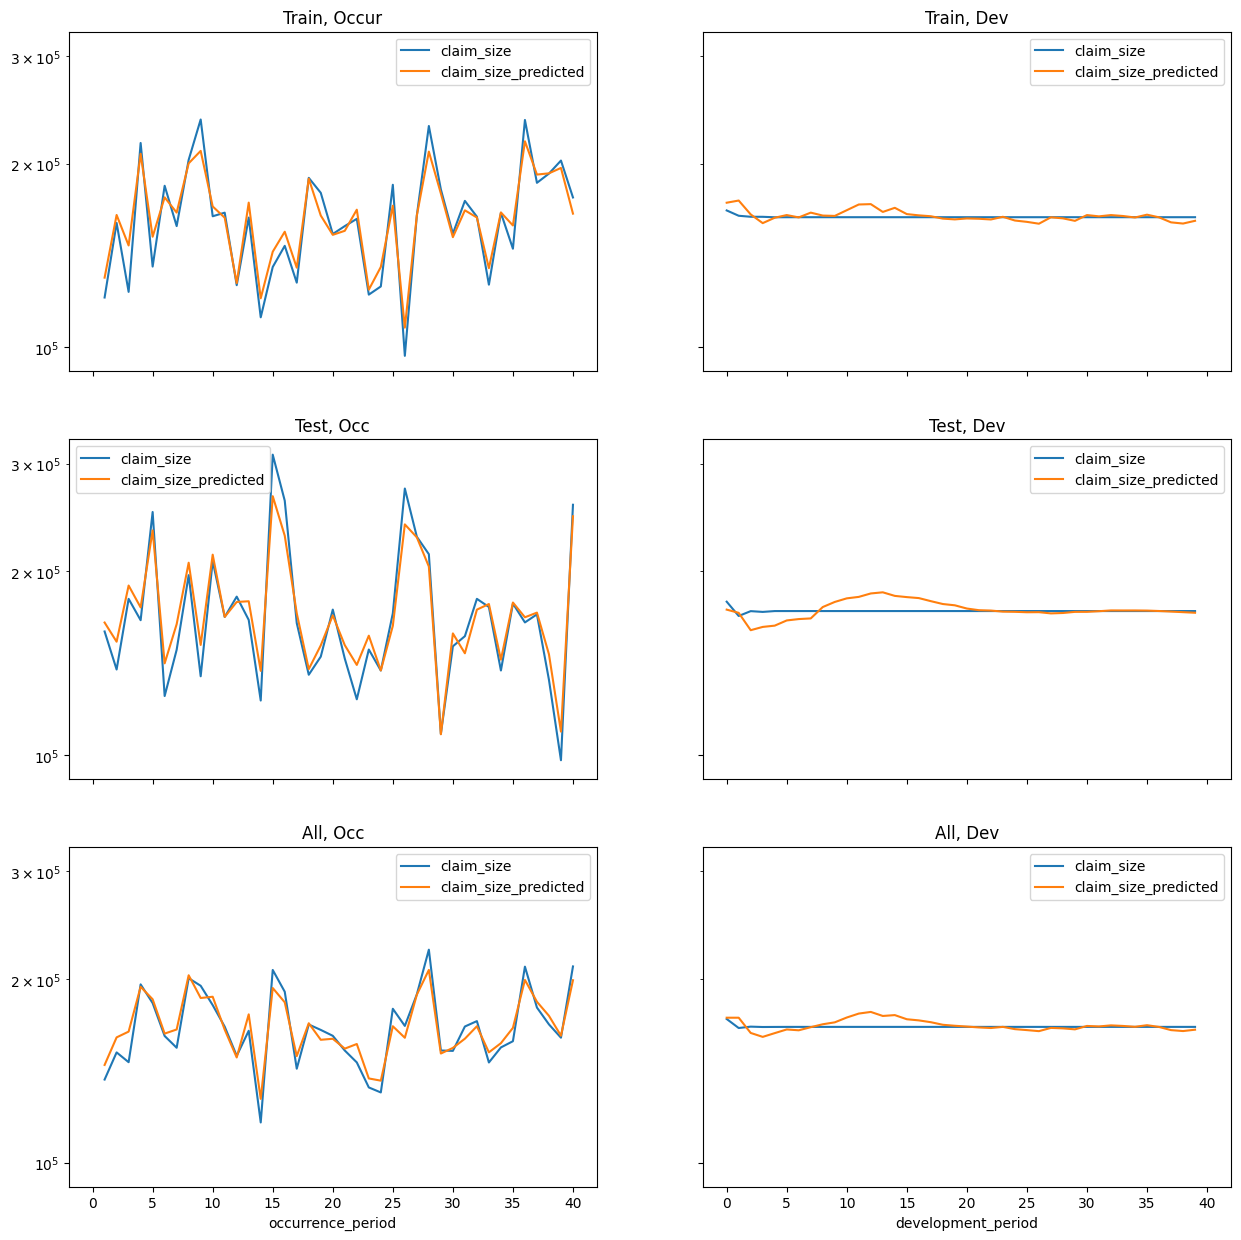

In [29]:
make_model_subplots(df_complete)

# Load results from training

In [30]:
training_results = np.load('/notebooks/GrowNet/Regression/results/datwTestTrainSplit_rmse.npz',
                           allow_pickle = True)

In [31]:
training_results['rmse']

array([[2.62729625e+05, 1.72212109e+05, 0.00000000e+00],
       [2.62649594e+05, 1.72132984e+05, 0.00000000e+00],
       [2.62456719e+05, 1.71974453e+05, 0.00000000e+00],
       [2.62154438e+05, 1.71704328e+05, 0.00000000e+00],
       [2.61639000e+05, 1.71288234e+05, 0.00000000e+00],
       [2.60856500e+05, 1.70659656e+05, 0.00000000e+00],
       [2.59934875e+05, 1.69917312e+05, 0.00000000e+00],
       [2.58750469e+05, 1.68813125e+05, 0.00000000e+00],
       [2.56835719e+05, 1.67349266e+05, 0.00000000e+00],
       [2.54762000e+05, 1.65447875e+05, 0.00000000e+00],
       [2.52282859e+05, 1.63560781e+05, 0.00000000e+00],
       [2.46858438e+05, 1.57243297e+05, 0.00000000e+00],
       [2.46476984e+05, 1.58929953e+05, 0.00000000e+00],
       [2.41000406e+05, 1.53156031e+05, 0.00000000e+00],
       [2.36342438e+05, 1.50697844e+05, 0.00000000e+00],
       [2.34763719e+05, 1.50618094e+05, 0.00000000e+00],
       [2.31755359e+05, 1.47914016e+05, 0.00000000e+00],
       [1.72074740e+07, 1.30605